<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_EGLMS_Project/blob/main/%5BExp_8%5DAnalyzing_the_Sensibility_of_Film_Review_Texts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. pip 설치 및 import




In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://sanghyu.tistory.com/170

In [7]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [1,533 kB]
Hit:14 http://p

In [8]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [9]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

Installing automake (A dependency for mecab-ko)
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists...
Reading

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1253k      0  0:00:01  0:00:01 --:--:-- 1253k
./configure: line 7378: /usr/bin/file: No such file or directory
In file included from viterbi.cpp:14:0:
param.h:30:13: warning: 'Target {anonymous}::lexical_cast(Source) [with Target = std::__cxx11::basic_string<char>; Source = std::_

In [1]:
import pandas as pd
import konlpy
import gensim
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import tensorflow as tf


In [2]:
print(pd.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.5
0.6.0
3.6.0


## 2. 데이터 준비와 확인

In [3]:
base_path = "/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석"
train_data = pd.read_table(base_path+'/ratings_train.txt')
test_data = pd.read_table(base_path+'/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 3. 데이터로더 구성

실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.


데이터의 중복 제거

NaN 결측치 제거

한국어 토크나이저로 토큰화

불용어(Stopwords) 제거

사전word_to_index 구성

텍스트 스트링을 사전 인덱스 스트링으로 변환

X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 


In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [7]:
for i in range(10):
    print(X_train[i])
    print(get_decoded_sentence(X_train[i], index_to_word))
    print('라벨: ', y_train[i])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0
[1028, 4, 11, 519, 549, 687, 5, 120, 4, 70, 1639, 52, 925, 1006, 15, 44, 391]
. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나
라벨:  1
[24, 205, 2]
재 <UNK>
라벨:  0
[8409, 158, 3925, 4, 4, 298, 94, 17, 6, 4, 4, 58, 3479]
이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정
라벨:  0
[2, 8894, 1108, 52, 2832, 60, 5, 14, 2758, 41, 1188, 35, 351, 42, 22, 40, 60, 2, 2, 427, 3102, 1766, 6]
익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던 <UNK> <UNK> 너무나 이뻐 보였 다
라벨:  1
[675, 2, 2, 131, 420, 185, 1547, 712, 65, 1694, 715, 53, 375, 192, 271, 5, 4, 69, 4, 11, 2179, 122, 750, 4]
<UNK> <UNK> 3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .
라벨:  0
[253, 381, 9, 384, 2012, 55, 15, 817, 6, 4]
긴장감 을 제대로 살려 내 지 못했 다 .
라벨:  0
[232, 1450, 144, 6, 425, 756, 2, 2, 52, 1532, 290, 99, 250, 4, 4, 28, 855, 29, 353, 652, 540, 509, 583, 6, 3318, 4, 8895, 22, 1460, 1460, 4, 4, 71, 304, 17, 6, 52, 104, 8, 77, 22, 2, 43]
반개 아깝 다 욕 나온다 <UNK> <UNK> 연기 생활 몇 년 인지 . . 정말 발 로 해도 그

## 4. 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포

적절한 최대 문장 길이 지정

keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [9]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [10]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [11]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 5. 모델 구성 및 validation set 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 1) LSTM




In [12]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(8, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 20)          200000    
                                                                 
 lstm (LSTM)                 (None, 8)                 928       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201,009
Trainable params: 201,009
Non-trainable params: 0
_________________________________________________________________


### 2) 1-D CNN

In [13]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 20)          200000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          2256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1808      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### 3) GlobalMaxPooling1D()

In [14]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 20   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 20)          200000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 168       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 200,177
Trainable params: 200,177
Non-trainable params: 0
_________________________________________________________________


In [15]:
# validation set 10000건 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(96182, 41)
(96182,)


## 6. 모델 훈련 개시

### 1) LSTM

In [16]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 5s 12ms/step - loss: 0.5104 - accuracy: 0.7650 - val_loss: 0.3679 - val_accuracy: 0.8425
Epoch 2/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3412 - accuracy: 0.8562 - val_loss: 0.3492 - val_accuracy: 0.8489
Epoch 3/20
188/188 [==============================] - 2s 8ms/step - loss: 0.3145 - accuracy: 0.8691 - val_loss: 0.3504 - val_accuracy: 0.8472
Epoch 4/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2979 - accuracy: 0.8767 - val_loss: 0.3551 - val_accuracy: 0.8467
Epoch 5/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2854 - accuracy: 0.8828 - val_loss: 0.3620 - val_accuracy: 0.8450
Epoch 6/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2722 - accuracy: 0.8899 - val_loss: 0.3606 - val_accuracy: 0.8474
Epoch 7/20
188/188 [==============================] - 2s 8ms/step - loss: 0.2601 - accuracy: 0.8950 - val_loss: 0.3703 - val_accuracy: 0.8474
Epoch

In [17]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.5964 - accuracy: 0.8295 - 4s/epoch - 3ms/step
[0.5964375138282776, 0.8294851183891296]


### 2) 1-D CNN

In [18]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 3s 8ms/step - loss: 0.5275 - accuracy: 0.7270 - val_loss: 0.3639 - val_accuracy: 0.8412
Epoch 2/20
188/188 [==============================] - 1s 7ms/step - loss: 0.3353 - accuracy: 0.8570 - val_loss: 0.3472 - val_accuracy: 0.8496
Epoch 3/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2955 - accuracy: 0.8773 - val_loss: 0.3440 - val_accuracy: 0.8505
Epoch 4/20
188/188 [==============================] - 1s 6ms/step - loss: 0.2653 - accuracy: 0.8930 - val_loss: 0.3529 - val_accuracy: 0.8476
Epoch 5/20
188/188 [==============================] - 1s 7ms/step - loss: 0.2343 - accuracy: 0.9089 - val_loss: 0.3656 - val_accuracy: 0.8466
Epoch 6/20
188/188 [==============================] - 1s 6ms/step - loss: 0.1999 - accuracy: 0.9255 - val_loss: 0.3859 - val_accuracy: 0.8449
Epoch 7/20
188/188 [==============================] - 1s 7ms/step - loss: 0.1652 - accuracy: 0.9419 - val_loss: 0.4244 - val_accuracy: 0.8398
Epoch 

In [19]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9466 - accuracy: 0.8133 - 3s/epoch - 2ms/step
[0.9465994238853455, 0.8132514357566833]


### 3) GlobalMaxPooling1D()

In [20]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
188/188 [==============================] - 2s 6ms/step - loss: 0.6067 - accuracy: 0.7394 - val_loss: 0.4712 - val_accuracy: 0.8155
Epoch 2/20
188/188 [==============================] - 1s 5ms/step - loss: 0.4014 - accuracy: 0.8331 - val_loss: 0.3725 - val_accuracy: 0.8359
Epoch 3/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3365 - accuracy: 0.8579 - val_loss: 0.3561 - val_accuracy: 0.8417
Epoch 4/20
188/188 [==============================] - 1s 5ms/step - loss: 0.3030 - accuracy: 0.8742 - val_loss: 0.3534 - val_accuracy: 0.8451
Epoch 5/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2787 - accuracy: 0.8858 - val_loss: 0.3571 - val_accuracy: 0.8458
Epoch 6/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2588 - accuracy: 0.8952 - val_loss: 0.3641 - val_accuracy: 0.8461
Epoch 7/20
188/188 [==============================] - 1s 5ms/step - loss: 0.2418 - accuracy: 0.9039 - val_loss: 0.3736 - val_accuracy: 0.8454
Epoch 

In [21]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5884 - accuracy: 0.8190 - 3s/epoch - 2ms/step
[0.5884045362472534, 0.8189881443977356]


## 7. Loss, Accuracy 그래프 시각화

### 1) LSTM

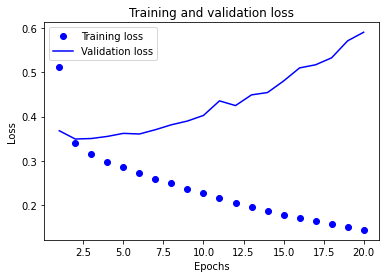

In [22]:
import matplotlib.pyplot as plt

history_dict = history_lstm.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


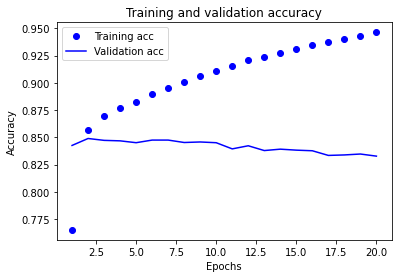

In [23]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2) 1-D CNN

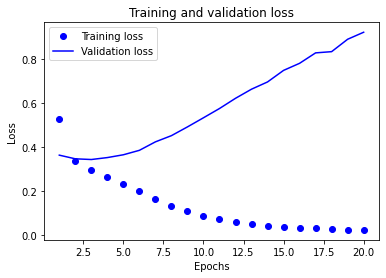

In [24]:
import matplotlib.pyplot as plt

history_dict = history_cnn.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


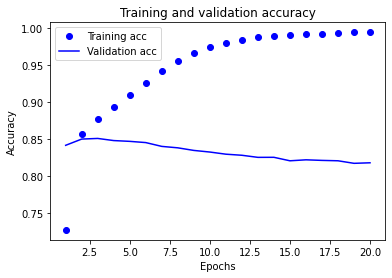

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### GlobalMaxPooling1D()

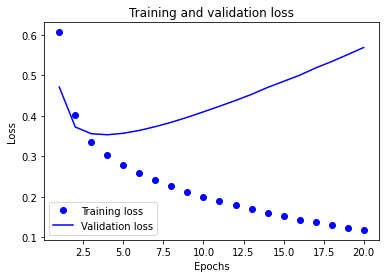

In [26]:
import matplotlib.pyplot as plt

history_dict = history_gmp.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


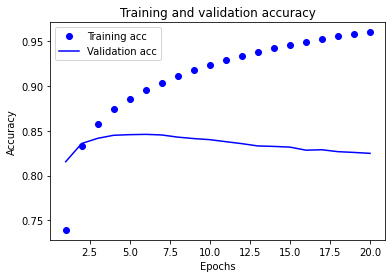

In [27]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8. 학습된 Embedding 레이어 분석

In [28]:
! pip list | grep gensim

gensim                        3.6.0


### 1) LSTM

In [29]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [30]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_lstm = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_lstm.txt'
f = open(word2vec_file_path_lstm, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_lstm, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("스릴러"))

[ 0.02482335  0.01067726 -0.10598735  0.04038537  0.00656468  0.01871243
 -0.04720517 -0.03842356  0.05936721 -0.04475024  0.00752002 -0.04685533
  0.09783196  0.10649409 -0.06548304  0.03262424 -0.00307993 -0.076489
  0.03617942 -0.03145432]
[('루이스', 0.876236617565155), ('인시디어스', 0.8455272912979126), ('취미', 0.8251104950904846), ('평타', 0.8183003067970276), ('권하', 0.8168163895606995), ('다음', 0.8160041570663452), ('계속', 0.8041096329689026), ('열광', 0.8026873469352722), ('서스펜스', 0.8010729551315308), ('기억', 0.7945011854171753)]


### 2) 1-D CNN

In [32]:
embedding_layer = model_cnn.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [33]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_cnn = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_cnn.txt'
f = open(word2vec_file_path_cnn, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_cnn.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [34]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_cnn, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("로맨스"))

[ 0.09066647  0.01725385  0.0287945   0.05119568  0.00599404  0.02821098
 -0.05378837 -0.04385294  0.01265117 -0.02546472  0.01917697  0.03891411
 -0.06023691 -0.05257557  0.06112032 -0.05383234 -0.01141982 -0.00244317
  0.01210707  0.02981336]
[('다물', 0.7744522094726562), ('발레', 0.7251303791999817), ('떤', 0.7200269103050232), ('픽션', 0.6925418972969055), ('오랫동안', 0.6911912560462952), ('어메이징', 0.6900569796562195), ('두말', 0.6817430257797241), ('본다', 0.6812683939933777), ('인한', 0.67986661195755), ('게끔', 0.6796427965164185)]


### 3) GlobalMaxPooling1D()

In [35]:
embedding_layer = model_gmp.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 20)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path_gmp = '/content/drive/MyDrive/인공지능/아이펠/ES/data/영화텍스트감성분석/data/word2vec_gmp.txt'
f = open(word2vec_file_path_gmp, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [37]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path_gmp, binary=False)
vector = word_vectors['영화']
print(vector)

print(word_vectors.similar_by_word("코미디"))

[-0.27059212 -0.17653966 -0.2100819  -0.22167234 -0.10940829 -0.27097654
 -0.2140306  -0.2925349  -0.15792991 -0.03471531 -0.27620375 -0.20496063
 -0.011888   -0.13527918 -0.21761829 -0.16602515 -0.18708149 -0.2252036
 -0.26998526 -0.24416257]
[('달린다', 0.9125566482543945), ('상', 0.8982319831848145), ('침묵', 0.8901704549789429), ('배우', 0.8851234316825867), ('너무', 0.866477906703949), ('보라', 0.8645331859588623), ('먹', 0.8634328842163086), ('국', 0.8575745820999146), ('진심', 0.8553153872489929), ('걸', 0.8531071543693542)]


## 9. 한국어 Word2Vec 임베딩 활용하여 성능 개선

### 1) Word2Vec 임베딩 적용

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_path = "/content/drive/MyDrive/error_model/word2vec_ko.model"
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv

In [39]:
vector.similar_by_word("액션")

[('코미디', 0.7429822683334351),
 ('스릴러', 0.7381718754768372),
 ('판타지', 0.6900153160095215),
 ('호러', 0.6892675757408142),
 ('SF', 0.6889280676841736),
 ('롤플레잉', 0.6625269651412964),
 ('영화', 0.6522793769836426),
 ('서스펜스', 0.645000696182251),
 ('어드벤처', 0.6273845434188843),
 ('미스터리', 0.6250677108764648)]

In [40]:
vector.similar_by_word("영화")

[('드라마', 0.8418774008750916),
 ('뮤지컬', 0.7775139808654785),
 ('코미디', 0.7489107251167297),
 ('다큐멘터리', 0.7401294708251953),
 ('헐리우드', 0.7397844791412354),
 ('애니메이션', 0.7170552015304565),
 ('독립영화', 0.7113527655601501),
 ('로맨틱', 0.7107658386230469),
 ('장편', 0.7101576328277588),
 ('극영화', 0.7045413255691528)]

In [41]:
vocab_size = 10000
word_vector_dim = 100

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
n = 0
for i in range(4,vocab_size):
    if index_to_word[i] in vector:
        embedding_matrix[i] = vector[index_to_word[i]]

### 2) 모델구현

In [43]:
from tensorflow.keras.initializers import Constant

- LSTM

In [44]:

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        input_length=maxlen,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=True))
model_lstm.add(tf.keras.layers.LSTM(512))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(tf.keras.layers.Dense(128, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(62, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 lstm_1 (LSTM)               (None, 512)               1255424   
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 62)                7998      
                                                                 
 dense_8 (Dense)             (None, 1)                 63        
                                                                 
Total params: 2,329,149
Trainable params: 2,329,149
Non-trainable params: 0
_________________________________________________________________


- 1-D CNN

In [45]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        input_length=maxlen,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=True))
model_cnn.add(tf.keras.layers.Conv1D(512, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(512, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())

model_cnn.add(tf.keras.layers.Dense(128, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(64, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 35, 512)           358912    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 512)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 512)            1835520   
                                                                 
 global_max_pooling1d_2 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_9 (Dense)             (None, 128)              

- GlobalMaxPooling1D

In [46]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size,
                                        word_vector_dim,
                                        input_length=maxlen,
                                        embeddings_initializer=Constant(embedding_matrix),
                                        trainable=True))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D()) 
model_gmp.add(tf.keras.layers.Dense(512, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(512, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.ㅏ
model_gmp.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 41, 100)           1000000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 512)               51712     
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,314,881
Trainable params: 1,314,881
Non-trainable params: 0
____________________________________________

## 3) compile 및 모델학습

In [47]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
            
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

- LSTM

In [48]:
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_lstm.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
1503/1503 [==============================] - 26s 15ms/step - loss: 0.4114 - accuracy: 0.8077 - val_loss: 0.3500 - val_accuracy: 0.8411
Epoch 2/35
1503/1503 [==============================] - 21s 14ms/step - loss: 0.2984 - accuracy: 0.8721 - val_loss: 0.3108 - val_accuracy: 0.8657
Epoch 3/35
1503/1503 [==============================] - 21s 14ms/step - loss: 0.2439 - accuracy: 0.8983 - val_loss: 0.3199 - val_accuracy: 0.8637
Epoch 4/35
1503/1503 [==============================] - 21s 14ms/step - loss: 0.1893 - accuracy: 0.9234 - val_loss: 0.3372 - val_accuracy: 0.8654
Epoch 5/35
1503/1503 [==============================] - 21s 14ms/step - loss: 0.1354 - accuracy: 0.9468 - val_loss: 0.4064 - val_accuracy: 0.8635
Epoch 6/35
1503/1503 [==============================] - 21s 14ms/step - loss: 0.0963 - accuracy: 0.9625 - val_loss: 0.5020 - val_accuracy: 0.8593
Epoch 7/35
1503/1503 [==============================] - 21s 14ms/step - loss: 0.0689 - accuracy: 0.9736 - val_loss: 0.5671 -

In [49]:
results = model_lstm.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.9811 - accuracy: 0.8520 - 6s/epoch - 4ms/step
[0.9810885190963745, 0.8519641160964966]


- 1-D CNN

In [50]:
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_cnn.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
1503/1503 [==============================] - 14s 9ms/step - loss: 0.4674 - accuracy: 0.7740 - val_loss: 0.4525 - val_accuracy: 0.7923
Epoch 2/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.3440 - accuracy: 0.8501 - val_loss: 0.3528 - val_accuracy: 0.8455
Epoch 3/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.2849 - accuracy: 0.8789 - val_loss: 0.3550 - val_accuracy: 0.8493
Epoch 4/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.2327 - accuracy: 0.9041 - val_loss: 0.3796 - val_accuracy: 0.8429
Epoch 5/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.1846 - accuracy: 0.9245 - val_loss: 0.4084 - val_accuracy: 0.8452
Epoch 6/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.1412 - accuracy: 0.9431 - val_loss: 0.4810 - val_accuracy: 0.8421
Epoch 7/35
1503/1503 [==============================] - 13s 9ms/step - loss: 0.1065 - accuracy: 0.9576 - val_loss: 0.5693 - val_ac

In [51]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 1.4503 - accuracy: 0.8389 - 4s/epoch - 3ms/step
[1.450316071510315, 0.8388632535934448]


- GlobalMaxPooling1D

In [52]:
epochs=35  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_gmp.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/35
1503/1503 [==============================] - 9s 5ms/step - loss: 0.6020 - accuracy: 0.6757 - val_loss: 0.5697 - val_accuracy: 0.6947
Epoch 2/35
1503/1503 [==============================] - 8s 5ms/step - loss: 0.5234 - accuracy: 0.7382 - val_loss: 0.4985 - val_accuracy: 0.7555
Epoch 3/35
1503/1503 [==============================] - 8s 5ms/step - loss: 0.4814 - accuracy: 0.7656 - val_loss: 0.4750 - val_accuracy: 0.7727
Epoch 4/35
1503/1503 [==============================] - 8s 5ms/step - loss: 0.4529 - accuracy: 0.7853 - val_loss: 0.4820 - val_accuracy: 0.7676
Epoch 5/35
1503/1503 [==============================] - 8s 5ms/step - loss: 0.4297 - accuracy: 0.8007 - val_loss: 0.4517 - val_accuracy: 0.7886
Epoch 6/35
1503/1503 [==============================] - 8s 5ms/step - loss: 0.4109 - accuracy: 0.8117 - val_loss: 0.4478 - val_accuracy: 0.7937
Epoch 7/35
1503/1503 [==============================] - 8s 5ms/step - loss: 0.3948 - accuracy: 0.8206 - val_loss: 0.4245 - val_accuracy:

In [53]:
results = model_gmp.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7407 - accuracy: 0.8078 - 3s/epoch - 2ms/step
[0.7406540513038635, 0.8077588081359863]


## 10. 85% 이상 모델 선정

- RNN의 레이어인 LSTM이 85% 이상을 달성하였다.
  - 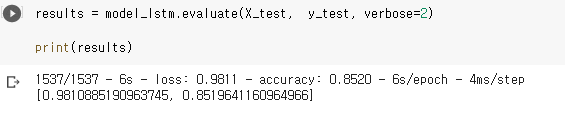